In [123]:
import re
import spacy
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords


sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from nltk import bigrams
import pickle

import os
import gensim

from pprint import pprint

import matplotlib.colors as mcolors
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim_models

In [77]:
pwd

'/Users/swagyangjh/Desktop/Research/event-sequence-analytics/Analysis'

In [78]:
survey = pd.read_csv("/Users/swagyangjh/Desktop/Processed_survey.csv")


# Seperate the the survey into 5 datasets

In [79]:
dataset0 = survey.loc[survey['Dataset']=='0']
dataset1 = survey.loc[survey['Dataset']=='1']
dataset2 = survey.loc[survey['Dataset']=='2']
dataset3 = survey.loc[survey['Dataset']=='3']
dataset4 = survey.loc[survey['Dataset']=='4']
dataset5 = survey.loc[survey['Dataset']=='5']

In [80]:
dataset0

,Source,Unnamed: 1,RecordedDate,Duration (in seconds),cf_insight1,cf_insight1_Justify,cf_insight_1_Timer_Page Submit,cf_insight2,cf_insight2_Justify,cf_insight2 Timer_Page Submit,...,ss_insight2_Justify,ss_insight2 Timer_Page Submit,ss_insight3,ss_insight3_Justify,ss_insight3 Timer_Page Submit,ss_Justification,Dataset,MSP,completionID,PROLIFIC_PID
1,Acquintance,Yes,3/8/2022 16:42:01,1777,Strongly agree,A direct link with number 100 shows this fact.,61.468,Somewhat disagree,24 more people also survived after going to th...,348.575,...,the third subplot also indicates the order of ...,127.141,Strongly disagree,The process described in the fact happens in s...,89.544,NaN,0,0,748611,6
2,Acquintance,Yes,3/8/2022 16:54:51,1682,Strongly agree,arrival -&gt; emergency = 100,55.097,Strongly disagree,38+24 = 62,51.254,...,37/37 and 20/24 are discharged alive after goi...,98.727,Strongly disagree,"23 people went through the process, not 22; an...",136.7,NaN,0,0,392479,6
3,Acquintance,Yes,3/8/2022 17:21:12,6092,Strongly agree,diagram says so,27.746,Strongly disagree,38 + 24 = 62 are discharged alive overall,32.08,...,37+20 =57 alive,41.932,Strongly disagree,18 out of 24 died,869.094,NaN,0,0,124322,5
4,MTurk,Yes,3/10/2022 18:06:13,664,Strongly agree,NaN,22.176,Agree,NaN,18.602,...,NaN,17.733,Somewhat disagree,NaN,28.47,These separate lines are a bit harder for me t...,0,0,345699,3
5,MTurk,Yes,3/10/2022 18:26:57,1867,Strongly agree,NaN,81.802,Strongly disagree,NaN,26.237,...,NaN,22.214,Disagree,NaN,173.19,The image data is difficult to read. the activ...,0,0,386402,5
6,Prolific,Yes,3/17/2022 15:42:44,839,Strongly agree,NaN,72.601,Agree,NaN,37.189,...,NaN,115.66,Strongly agree,NaN,29.767,The quality of the image is alright and the fa...,0,1,747614,61fa9015d42cb19beec4905e
7,Prolific,Yes,3/18/2022 9:22:52,431,Somewhat disagree,NaN,60.7,Somewhat agree,NaN,23.341,...,NaN,16.914,Somewhat agree,NaN,57.09,"it shows 37 as arriving, emergency then being ...",0,1,356752,5a78e410ae9a0b0001a97274
8,Prolific,Yes,3/19/2022 17:52:17,418,Strongly agree,NaN,23.156,Strongly agree,NaN,163.691,...,NaN,15.634,Strongly disagree,NaN,26.49,It's easy to understand because it's step by step,0,1,571834,5efc1c8ea9f30301deb3ae10
9,Acquintance,Yes,3/9/2022 1:45:19,2848,Strongly agree,known graph structure,29.631,Strongly agree,Known graph,31.417,...,Just by noticing the 2nd vertical bar,87.837,Neither agree nor disagree,Not sure if the followed the sequence from the...,146.824,NaN,0,1,642069,6
10,Acquintance,Yes,3/18/2022 20:12:52,1854,Strongly agree,NaN,16.383,Disagree,NaN,29.891,...,NaN,53.325,Disagree,NaN,88.852,easy to understand. but not all the activitie...,0,1,116126,6


In [82]:
justification = dataset0['cf_Justification']
justification
clean_justification = justification.dropna(axis=0,how='all')  
clean_justification = clean_justification[:]
clean_justification.head()

4    It seems a fairly simple image. Only three bra...
5    The image is easy to understand, 24 patients w...
6    The quality of the image is okay, just that th...
7    62 people went to the icu but only 60 are acco...
8    You can't tell if they went back to the ICU af...
Name: cf_Justification, dtype: object

# Extend Stopwords

In [137]:

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'image','edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'rather', 'lot', 'make', 'want', 'seem', 'run', 'need', 'even', 'even', 'also', 'may', 'take', 'come'])


# Tokenize the sentences and Clean it

In [84]:
def sent_to_words(sentences):
    for sent in sentences:
        
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [85]:
data = clean_justification.tolist()

data_words = list(sent_to_words(data))

data_words

[['it', 'seems', 'fairly', 'simple', 'image', 'only', 'three', 'branches'],
 ['the',
  'image',
  'is',
  'easy',
  'to',
  'understand',
  'patients',
  'went',
  'to',
  'floor',
  'and',
  'got',
  'discharged',
  'alive',
  'other',
  'facts',
  'are',
  'not',
  'shown',
  'in',
  'the',
  'image'],
 ['the',
  'quality',
  'of',
  'the',
  'image',
  'is',
  'okay',
  'just',
  'that',
  'the',
  'last',
  'fact',
  'did',
  'not',
  'match',
  'the',
  'description',
  'on',
  'the',
  'image'],
 ['people',
  'went',
  'to',
  'the',
  'icu',
  'but',
  'only',
  'are',
  'accounted',
  'for',
  'between',
  'dying',
  'or',
  'moving',
  'to',
  'the',
  'floor',
  'so',
  'there',
  'are',
  'people',
  'unaccounted',
  'for'],
 ['you',
  'cant',
  'tell',
  'if',
  'they',
  'went',
  'back',
  'to',
  'the',
  'icu',
  'after',
  'being',
  'on',
  'the',
  'floor'],
 ['the',
  'activities',
  'in',
  'the',
  'fact',
  'are',
  'not',
  'shown',
  'in',
  'the',
  'image'],


In [104]:
# remove stopwords
sentences=[]
for line in data_words:
    try:
        segs = [i for i in line if i not in stop_words]
        sentences.append(segs)
    except:
        print (line)
        continue

In [105]:
sentences

[['seems', 'fairly', 'simple', 'three', 'branches'],
 ['easy',
  'understand',
  'patients',
  'went',
  'floor',
  'got',
  'discharged',
  'alive',
  'facts',
  'shown'],
 ['quality', 'okay', 'last', 'fact', 'match', 'description'],
 ['people',
  'went',
  'icu',
  'accounted',
  'dying',
  'moving',
  'floor',
  'people',
  'unaccounted'],
 ['cant', 'tell', 'went', 'back', 'icu', 'floor'],
 ['activities', 'fact', 'shown'],
 ['nothing',
  'shows',
  'going',
  'back',
  'behavior',
  'continued',
  'along',
  'discharge',
  'alive',
  'path'],
 ['chart',
  'spaced',
  'well',
  'little',
  'ambiguity',
  'outcome',
  'clearly',
  'labeled',
  'everyone',
  'accounted'],
 ['isnt', 'split', 'floor'],
 ['average', 'understanding'],
 ['discharged', 'fact', 'fact'],
 ['difficulty', 'trying', 'rate', 'people', 'floor'],
 ['easier',
  'understand',
  'two',
  'prior',
  'still',
  'without',
  'fully',
  'accounting',
  'everyone',
  'arrived',
  'chart',
  'clinical',
  'meaning'],
 ['acco

In [106]:
# Create Dictionary
id2word = Dictionary(sentences)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in sentences]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [107]:
for topic in lda_model.print_topics(num_topics=10, num_words=10):
    print (topic[1])

0.102*"number" + 0.102*"answer" + 0.102*"based" + 0.062*"figure" + 0.033*"images" + 0.033*"questions" + 0.033*"accurately" + 0.033*"represents" + 0.033*"another" + 0.004*"nothing"
0.109*"patients" + 0.109*"discharged" + 0.073*"fact" + 0.065*"alive" + 0.058*"going" + 0.055*"understand" + 0.055*"back" + 0.053*"shown" + 0.046*"easy" + 0.036*"went"
0.211*"icu" + 0.105*"floor" + 0.096*"people" + 0.071*"happens" + 0.055*"die" + 0.039*"cant" + 0.039*"isnt" + 0.037*"went" + 0.022*"tell" + 0.014*"back"
0.118*"information" + 0.038*"right" + 0.038*"diagram" + 0.038*"branch" + 0.038*"follow" + 0.038*"linear" + 0.038*"move" + 0.038*"paths" + 0.038*"find" + 0.037*"missing"
0.045*"understanding" + 0.045*"average" + 0.006*"numbers" + 0.006*"presented" + 0.006*"normal" + 0.006*"align" + 0.006*"data" + 0.006*"depicted" + 0.006*"activity" + 0.006*"er"
0.138*"fairly" + 0.036*"branches" + 0.036*"seems" + 0.036*"simple" + 0.036*"three" + 0.005*"based" + 0.005*"happens" + 0.005*"discharged" + 0.005*"show" + 

In [108]:
# 
# structure the main topic
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp[:10]])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.849999,"fairly, branches, seems, simple, three, based, happens, discharged, show, continues","[seems, fairly, simple, three, branches]"
1,1,1.0,0.918179,"patients, discharged, fact, alive, going, understand, back, shown, easy, went","[easy, understand, patients, went, floor, got, discharged, alive, facts, shown]"
2,2,1.0,0.871424,"patients, discharged, fact, alive, going, understand, back, shown, easy, went","[quality, okay, last, fact, match, description]"
3,3,2.0,0.909997,"icu, floor, people, happens, die, cant, isnt, went, tell, back","[people, went, icu, accounted, dying, moving, floor, people, unaccounted]"
4,4,2.0,0.871419,"icu, floor, people, happens, die, cant, isnt, went, tell, back","[cant, tell, went, back, icu, floor]"
5,5,1.0,0.774999,"patients, discharged, fact, alive, going, understand, back, shown, easy, went","[activities, fact, shown]"
6,6,1.0,0.918180,"patients, discharged, fact, alive, going, understand, back, shown, easy, went","[nothing, shows, going, back, behavior, continued, along, discharge, alive, path]"
7,7,9.0,0.918181,"clearly, chart, activity, explained, normal, everyone, accounted, outcome, ambiguity, little","[chart, spaced, well, little, ambiguity, outcome, clearly, labeled, everyone, accounted]"
8,8,2.0,0.774997,"icu, floor, people, happens, die, cant, isnt, went, tell, back","[isnt, split, floor]"
9,9,4.0,0.699998,"understanding, average, numbers, presented, normal, align, data, depicted, activity, er","[average, understanding]"


In [110]:
"""get samples of sentences that most represent a given topic."""
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.637514,"number, answer, based, figure, images, questions, accurately, represents, another, nothing","[images, easy, understand, answer, questions, accurately, based]"
1,1.0,0.918180,"patients, discharged, fact, alive, going, understand, back, shown, easy, went","[nothing, shows, going, back, behavior, continued, along, discharge, alive, path]"
2,2.0,0.909997,"icu, floor, people, happens, die, cant, isnt, went, tell, back","[people, went, icu, accounted, dying, moving, floor, people, unaccounted]"
3,3.0,0.629622,"information, right, diagram, branch, follow, linear, move, paths, find, missing","[find, easy, follow, linear, diagram, understand, paths, patients, information, missing, right, ..."
4,4.0,0.699998,"understanding, average, numbers, presented, normal, align, data, depicted, activity, er","[average, understanding]"
5,5.0,0.849999,"fairly, branches, seems, simple, three, based, happens, discharged, show, continues","[seems, fairly, simple, three, branches]"
6,6.0,0.606981,"show, third, downwardwe, correct, however, graph, appears, whether, exactly, interpreting","[quite, easy, understand, least, fairly, certain, interpreting, correctly, however, able, verify..."
7,7.0,0.508347,"dont, er, data, normal, numerically, included, visualized, wrong, literally, anything","[dont, happen, might, back, icu, dont, number, going, arrival, er, shown]"
8,8.0,0.721474,"two, without, arrived, clinical, easier, fully, meaning, prior, still, accounting","[easier, understand, two, prior, still, without, fully, accounting, everyone, arrived, chart, cl..."
9,9.0,0.918181,"clearly, chart, activity, explained, normal, everyone, accounted, outcome, ambiguity, little","[chart, spaced, well, little, ambiguity, outcome, clearly, labeled, everyone, accounted]"


In [138]:
type(sent_topics_sorteddf_mallet)

pandas.core.frame.DataFrame

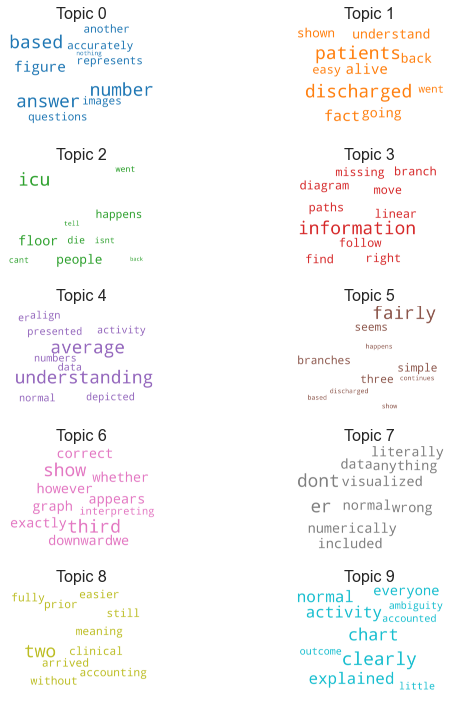

In [111]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [112]:

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


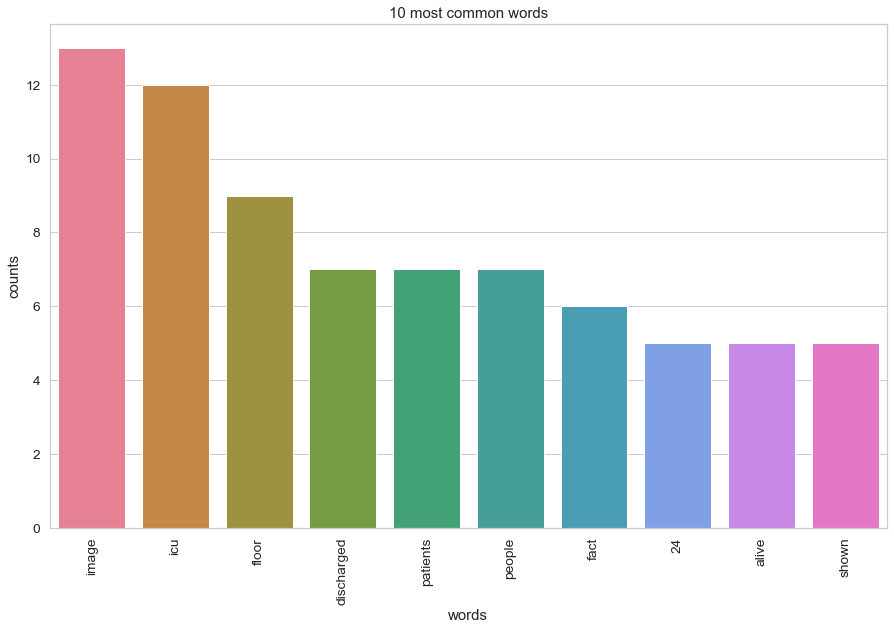

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(clean_justification)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [114]:
# delete the bigrams which do not contain topic words
def word_drop_keywords(x):
    arr = [i.strip() for i in  x[0].split(",") if i.strip() ]
    if len(arr) >=5:
        key_words = arr[:5]
    else:
        key_words = arr
    words = x[1]
    keep_words = []
    for i in range(len(words)):
        
        if i == 0:
            if len(set(words[i:i+1])&set(key_words)) > 0 :
                
                keep_words.append(words[i])
        elif i < len(words)-1 and i > 0:
            if len(set(words[i:i+2])&set(key_words)) > 0 or len(set(words[i-1:i+1])&set(key_words)) > 0 :

                keep_words.append(words[i])
        else:
            if words[i-1] in key_words:
                keep_words.append(words[i])
    return keep_words

In [115]:
new_text = df_dominant_topic[["Keywords","Text"]].apply(lambda x:word_drop_keywords(x),axis=1)
new_text = [i for i in new_text if len(i) >0]


In [116]:
new_data = [" ".join(i) for i in new_text ]
new_data

['seems fairly simple three branches',
 'understand patients went got discharged alive facts',
 'last fact match',
 'people went icu accounted moving floor people unaccounted',
 'back icu floor',
 'fact shown',
 'shows going back discharge alive path',
 'chart spaced outcome clearly labeled',
 'split',
 'average understanding',
 'discharged fact fact',
 'rate people floor',
 'easier understand two prior still without fully everyone arrived chart clinical meaning',
 'chart discharged alive zero going back',
 'images easy understand answer questions accurately',
 'people missing icu either floor die',
 'easy follow linear diagram understand patients information missing right branch patients',
 'tell happens icu people die',
 'figure represents another number shown',
 'activity normal floor clearly explained',
 'dont happen icu dont number arrival er shown',
 'room third discarged alive third face',
 'alive er numerically wrong went normal floor included data visualized',
 'correctly howe

In [117]:
# keep N, adj, verb,adv,
# text preprocessing
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        # print(sent)
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(new_data) 


In [118]:
data_ready

[['fairly', 'simple', 'branch'],
 ['patient', 'discharge', 'alive', 'fact'],
 ['last', 'fact', 'match'],
 ['people', 'icu', 'account', 'move', 'floor', 'people', 'unaccounte'],
 ['back', 'icu', 'floor'],
 ['fact', 'show'],
 ['show', 'discharge', 'alive', 'path'],
 ['outcome', 'clearly', 'label'],
 [],
 ['average', 'understanding'],
 ['discharged', 'fact'],
 ['rate', 'people', 'floor'],
 ['easy',
  'understand',
  'prior',
  'still',
  'fully',
  'arrive',
  'clinical',
  'meaning'],
 ['alive'],
 ['easy', 'understand', 'answer', 'question', 'accurately'],
 ['people', 'miss', 'icu', 'floor', 'die'],
 ['understand',
  'patient',
  'information',
  'miss',
  'right',
  'branch',
  'patient'],
 ['tell', 'icu', 'people', 'die'],
 ['figure', 'represent', 'number', 'show'],
 ['activity', 'normal', 'floor', 'clearly', 'explain'],
 ['happen', 'icu', 'number', 'arrival', 'show'],
 ['discarge', 'alive', 'third', 'face'],
 ['alive',
  'numerically',
  'wrong',
  'normal',
  'floor',
  'include',
  

In [139]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
type(vis)

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


pyLDAvis._prepare.PreparedData

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/op